## **Testing**

In [2]:
import torch
from models.IRSeNet import IRSeNet
from models.MobileNet import MobileNet
import torch.nn.functional as F

In [3]:
model = torch.load('/workspace/SurveillanceAI/src/arcface/weights/mobilenet.pt')
model.cuda()

MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [4]:
# count no of parameters'
total_params = sum(p.numel() for p in model.parameters())
total_params

1200512

## **Testing**

In [5]:
path = "/workspace/SurveillanceAI/src/arcface/data/faces"

from PIL import Image
from tqdm import tqdm
import os

main_image = Image.open('/workspace/SurveillanceAI/src/arcface/data/faces/rajat_kapoor/0adad8a276.jpg')

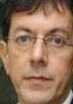

In [6]:
display(main_image)

In [7]:
# convert image1 to pytorch tensor
import torchvision.transforms as transforms
transform = transforms.Compose([
        transforms.Resize((112, 112), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225]),
    ])
device = 'cuda'
main_image = transform(main_image).unsqueeze(0).to(device)


In [72]:
def do_inference(imgs):
    for i in range(len(imgs)):
        imgs[i] = Image.open(imgs[i])
        imgs[i] = transform(imgs[i])    
    
    imgs = torch.stack(imgs).to(device)
    output = model(imgs)
    # outputs {num_emb, emb_dim} normalize for every vector
    output = F.normalize(output, dim=-1)
    return output

In [1]:
cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
top_10 = []
model.eval()

# Load and preprocess the main image
method = 'avg'
with torch.no_grad():
    main_emb = model(main_image)

    data_path = "/workspace/SurveillanceAI/src/arcface/data/faces"

    for folder_label in tqdm(os.listdir(data_path)):
        imgs = []
        for faces in os.listdir(os.path.join(data_path, folder_label)):
            imgs.append(os.path.join(data_path, folder_label, faces))

        embeddings = do_inference(imgs)

        if method == 'all':
            for i, vector in enumerate(embeddings):
                cos_sim = cos(vector, main_emb)
                # Store the cosine similarity and the image path
                top_10.append((cos_sim.item(), folder_label))

        if method == 'avg':
            embeddings = embeddings
            avg_embedding = torch.mean(embeddings, dim=0)
            cos_sim = cos(avg_embedding, main_emb)
            # Store the cosine similarity and the folder label
            top_10.append((cos_sim.item(), folder_label))

# Sort the list of (cos_sim, path/folder_label) tuples by cosine similarity in descending order
top_10.sort(key=lambda x: x[0], reverse=True)

# Get the top ten results
top_10 = top_10[:10]

# Print or use the top 10 results as needed
for similarity, path_or_label in top_10:
    print(f"Cosine Similarity: {similarity}, Path/Folder Label: {path_or_label}")


NameError: name 'torch' is not defined

## **Weight Transformation**

In [ ]:
weight = torch.load("/workspace/SurveillanceAI/src/arcface/weights/model_ir_se50.pth")
new_weight = {'model.'+k: v for k, v in weight.items()}
model = IRSeNet()
model.load_state_dict(new_weight)
torch.save(model, "/workspace/SurveillanceAI/src/arcface/weights/irsenet.pt")

## **Convert Model**

In [10]:
import torch
import onnx

model = torch.load('/workspace/SurveillanceAI/src/arcface/weights/mobilenet.pt')
model.eval()
dummy_input = torch.randn(1, 3, 112, 112, requires_grad=True).cuda()

onnx_model_path = '/workspace/SurveillanceAI/src/arcface/weights/mobilenet.onnx'

In [12]:
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  onnx_model_path,        # where to save the model
                  export_params=True,  # store the trained parameter weights inside the model file
                )

=========== Diagnostic Run torch.onnx.export version 2.1.0a0+29c30b1 ===========
verbose: False, log level: 40
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

